## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

I defined a seperate function for each sequential step such that we can vary different numbers of parameters

In [3]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_seq(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    add_noise=0.2
    
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    
    if (len(thetas)==2):
        a1 = thetas[0]
        b = thetas[1]
        
        if not add_noise == None:
            a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)  
            
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
        
        return y[x<cp1]
    
     
    if (len(thetas)==3):     
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        
        if not add_noise == None:
            a1,b, a2 = np.array([a1,b, a2]) + scp.random.normal(scale=add_noise,size=3)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
        
        return y[x<cp2]
    
    
    if (len(thetas)==4):
        
        
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        a3 = thetas[3]
        
        if not add_noise == None:
            a1,b, a2, a3 = np.array([a1,b, a2, a3]) + scp.random.normal(scale=add_noise,size=4)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
        # third piece
        y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
        
        return y

    
  

### Define prior and summary stats dependent on prior

In [4]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



**Summary statistics**

I defined a few more summary statistics such that we have 13 in total.

In [71]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        step_size = max_time/len(batch)
        
        
        x = torch.arange(0, max_time, step_size, dtype=torch.float64)
        
        
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(10) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = np.nanargmin(batch[x<4])   #value of min
    

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[3] = np.nanmax(batch[(x>=4)&(x<8)])
            s[4] = np.nanmin(batch[(x>=4)&(x<8)])
            s[5] = np.nanargmin(batch[(x>=4)&(x<8)])

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[6] = np.nanmin(batch[x>=5])
            s[7] = np.nanargmin(batch[x>=5])
            
            s[8] = np.nanmax(batch[x>=5])
            s[9] = np.nanargmax(batch[x>=5])
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    
    

## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [72]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

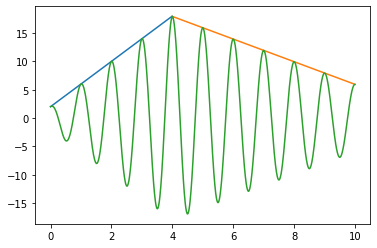

In [73]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [74]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    
    return_factors=False
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

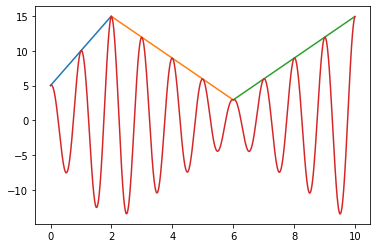

In [75]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

## Sequential Time Series SBI


We have the follwoing parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [76]:
#parameter a1,b,a2,a3, cp1, cp2



prior_min = [3, 3, -5, 0]  

prior_max = [7, 7, -1, 4]

num_simulations=300

## First round

In [77]:
### first round:

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])

print(prior_min[0:2])
print(prior1)

inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

[3, 3]
BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


/tmp/ipykernel_14053/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_14053/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [78]:
x = extract_sumstats(x_without)

In [79]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 83 epochs.


In [80]:
true_params = [5, 5]
obs_real = piecewise_linear_seq(true_params)


print(obs_real.shape)

obs_real_stats = extract_sumstats([obs_real])


print(obs_real_stats.shape)

torch.Size([300])
torch.Size([1, 10])


In [81]:
num_samples = 100

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
samples_0 = []

for i in samples:
    samples_0.append(i[0])
print(samples_0)

[tensor(4.9260), tensor(4.3286), tensor(4.6394), tensor(4.8320), tensor(4.4823), tensor(4.6292), tensor(4.7968), tensor(4.3897), tensor(4.7243), tensor(5.4602), tensor(4.7806), tensor(4.8317), tensor(4.4313), tensor(4.6678), tensor(4.8629), tensor(4.6914), tensor(4.9000), tensor(5.0511), tensor(4.7211), tensor(4.8488), tensor(4.2359), tensor(4.9717), tensor(4.9384), tensor(4.7525), tensor(4.8563), tensor(4.6995), tensor(5.0288), tensor(5.2221), tensor(4.8079), tensor(5.0464), tensor(5.0930), tensor(4.8491), tensor(5.3213), tensor(5.0277), tensor(4.9865), tensor(4.6172), tensor(4.4966), tensor(4.8557), tensor(5.1311), tensor(4.8271), tensor(4.5844), tensor(5.0876), tensor(5.4863), tensor(5.1762), tensor(4.6957), tensor(4.3982), tensor(4.9658), tensor(4.5805), tensor(4.1731), tensor(4.7003), tensor(4.7483), tensor(4.6652), tensor(5.1759), tensor(4.8825), tensor(5.1781), tensor(5.0382), tensor(4.7365), tensor(4.9364), tensor(5.0625), tensor(4.4995), tensor(4.6973), tensor(5.6079), tensor(

6.3106503
3.8634512


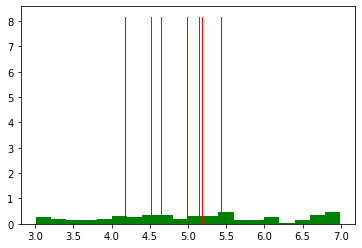

In [83]:
### comparing samples range from posterior and prior:
data = np.random.uniform(prior_min[0],prior_max[0],100) # You are generating 1000 points between 0 and 1.

plt.hist(data, 20, facecolor='green', density=True) 
plt.hist(samples_0, 20, facecolor='red', density=True)


print(np.max(samples_0))
print(np.min(samples_0))

In [84]:
print(prior_max[0]-prior_min[0])
print(np.max(samples_0)-np.min(samples_0))

4
2.447199


In [85]:
100/(4/0.631)

15.775

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [86]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:3], high = prior_max[2:3])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[4.6672, 4.9549]])
theta prior tensor([[-1.8502]])
theta tensor([[ 4.6672,  4.9549, -1.8502]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[4.9206, 4.7603]])
theta prior tensor([[-4.3265]])
theta tensor([[ 4.9206,  4.7603, -4.3265]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[5.9038, 4.8317]])
theta prior tensor([[-3.5401]])
theta tensor([[ 5.9038,  4.8317, -3.5401]])
tensor([-4.3348])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[5.6061, 4.9022]])
theta prior tensor([[-3.8896]])
theta tensor([[ 5.6061,  4.9022, -3.8896]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[5.2613, 4.6802]])
theta prior tensor([[-3.9835]])
theta tensor([[ 5.2613,  4.6802, -3.9835]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[5.0219, 3.3486]])
theta prior tensor([[-1.1193]])
theta tensor([[ 5.0219,  3.3486, -1.1193]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 2])
theta prior size torch.Size([2, 1])
2
theta_posterior tensor([[4.3562, 5.3959],
        [5.0328, 3.2453]])
theta prior tensor([[-2.8589],
        [-4.5413]])
theta tensor([[ 4.3562,  5.3959, -2.8589],
        [ 5.0328,  3.2453, -4.5413]])


/tmp/ipykernel_14053/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_14053/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[5.2129, 3.5347]])
theta prior tensor([[-3.8865]])
theta tensor([[ 5.2129,  3.5347, -3.8865]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[4.9532, 4.6605]])
theta prior tensor([[-2.1246]])
theta tensor([[ 4.9532,  4.6605, -2.1246]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[5.0274, 4.9857]])
theta prior tensor([[-3.6340]])
theta tensor([[ 5.0274,  4.9857, -3.6340]])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta pos size torch.Size([300, 2])
theta prior size torch.Size([300, 1])
2
theta_posterior tensor([[4.6648, 4.5736],
        [4.7102, 4.6963],
        [5.0036, 5.5515],
        [4.7366, 4.7523],
        [4.7449, 5.1942],
        [4.6885, 4.9882],
        [4.7135, 4.8198],
        [4.7034, 4.9018],
        [4.8407, 4.2575],
        [5.0492, 3.4007],
        [4.9208, 4.8954],
        [4.7731, 4.6406],
        [4.9745, 4.5093],
        [5.0521, 4.4812],
        [4.8660, 5.5475],
        [4.6241, 5.0287],
        [5.0574, 4.8111],
        [5.1723, 4.4326],
        [4.9630, 4.8002],
        [4.8102, 4.8070],
        [4.8144, 4.2604],
        [4.7652, 4.0978],
        [4.5822, 4.8751],
        [5.3730, 4.2937],
        [5.3880, 5.1301],
        [4.1540, 4.6850],
        [4.2763, 4.4222],
        [4.4694, 4.7995],
        [4.6332, 5.5044],
        [4.9157, 4.3380],
        [4.6607, 4.1882],
        [4.9851, 4.3877],
        [4.8749, 4.4515],
        [5.1293, 5.0090],
        [4.9480, 4.6768]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [87]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

Neural network successfully converged after 94 epochs.


In [88]:
true_params = [5,5,-3]


obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

## Third and last round

In [89]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=prior_min[3:4], high = prior_max[3:4])


prior_combined2 = Combined(proposal2, prior3, number_params_1=3)



inf = SNPE_C(prior_combined2, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined2)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 4.9693,  4.7916, -3.0874]])
theta prior tensor([[1.6156]])
theta tensor([[ 4.9693,  4.7916, -3.0874,  1.6156]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.9550,  4.9095, -2.5542]])
theta prior tensor([[2.4175]])
theta tensor([[ 4.9550,  4.9095, -2.5542,  2.4175]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 5.0837,  4.9788, -2.9850]])
theta prior tensor([[0.2401]])
theta tensor([[ 5.0837,  4.9788, -2.9850,  0.2401]])
tensor([2.3061])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.8183,  5.0406, -3.0450]])
theta prior tensor([[0.0704]])
theta tensor([[ 4.8183,  5.0406, -3.0450,  0.0704]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 5.1626,  4.9201, -3.0526]])
theta prior tensor([[0.6397]])
theta tensor([[ 5.1626,  4.9201, -3.0526,  0.6397]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 5.3231,  5.0520, -2.8588]])
theta prior tensor([[1.9742]])
theta tensor([[ 5.3231,  5.0520, -2.8588,  1.9742]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 3])
theta prior size torch.Size([2, 1])
2
theta_posterior tensor([[ 5.2015,  4.6966, -2.8505],
        [ 4.8144,  4.4710, -2.9706]])
theta prior tensor([[2.0116],
        [1.7233]])
theta tensor([[ 5.2015,  4.6966, -2.8505,  2.0116],
        [ 4.8144,  4.4710, -2.9706,  1.7233]])


/tmp/ipykernel_14053/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_14053/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 5.1530,  4.7931, -3.0025]])
theta prior tensor([[0.1365]])
theta tensor([[ 5.1530,  4.7931, -3.0025,  0.1365]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 4.9328,  5.2289, -3.1017]])
theta prior tensor([[0.4262]])
theta tensor([[ 4.9328,  5.2289, -3.1017,  0.4262]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 5.3942,  5.0056, -3.1602]])
theta prior tensor([[1.4327]])
theta tensor([[ 5.3942,  5.0056, -3.1602,  1.4327]])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta pos size torch.Size([300, 3])
theta prior size torch.Size([300, 1])
2
theta_posterior tensor([[ 5.0212,  4.8488, -3.0055],
        [ 5.1197,  4.9138, -3.0960],
        [ 5.4294,  4.8775, -3.0213],
        [ 5.0171,  4.9462, -3.3050],
        [ 5.0655,  4.7522, -3.0471],
        [ 4.8056,  4.8144, -2.9993],
        [ 5.2990,  4.9703, -3.0221],
        [ 5.3575,  4.8121, -3.0115],
        [ 4.9725,  5.0615, -3.0579],
        [ 5.0679,  4.9167, -3.1097],
        [ 4.8697,  4.7603, -2.5139],
        [ 5.4912,  4.7322, -3.5680],
        [ 5.4404,  4.6780, -3.1192],
        [ 5.0418,  4.8314, -2.9181],
        [ 5.3745,  4.7266, -3.0455],
        [ 5.1240,  4.9406, -2.9672],
        [ 4.8862,  4.9713, -3.0552],
        [ 6.0349,  4.7094, -3.6307],
        [ 4.6127,  5.1689, -3.0651],
        [ 5.9518,  4.9840, -2.9658],
        [ 5.0146,  4.8858, -3.0033],
        [ 5.2848,  4.9043, -3.2282],
        [ 5.0380,  5.1101, -2.6489],
        [ 5.3042,  4.6687, -3.2204],
        [ 5.4993,  4

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [90]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

Neural network successfully converged after 55 epochs.


In [91]:
num_samples = 1000


true_params = [5, 5, -3, 2]

obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])[0]

print(obs_real_stats)


samples = posterior3.sample((num_samples,), x=obs_real_stats)


prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)

tensor([  5.0310,   5.0310,   0.0000,  17.4613,  11.5892, 199.0000,  11.5892,
         99.0000,  18.6653, 499.0000])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [92]:
end = get_time()


print('start:', start, '\nend:', end)

start: 12-08-2021_17:06:19 
end: 12-08-2021_17:32:03


In [93]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples)


s_x_prior = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples_prior)

In [94]:
s_x_stat = extract_sumstats(s_x)

s_x_prior_stat = extract_sumstats(s_x_prior)



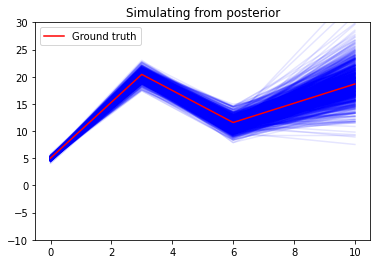

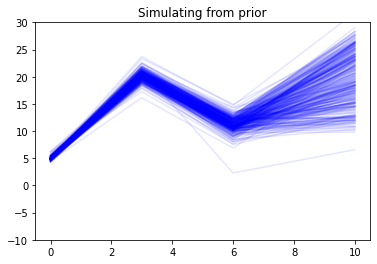

In [95]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


  

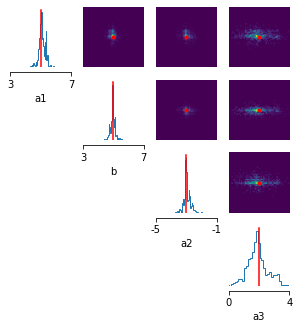

In [96]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2]])

parameter_names = ['a1', 'b', 'a2', 'a3' ]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

10
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


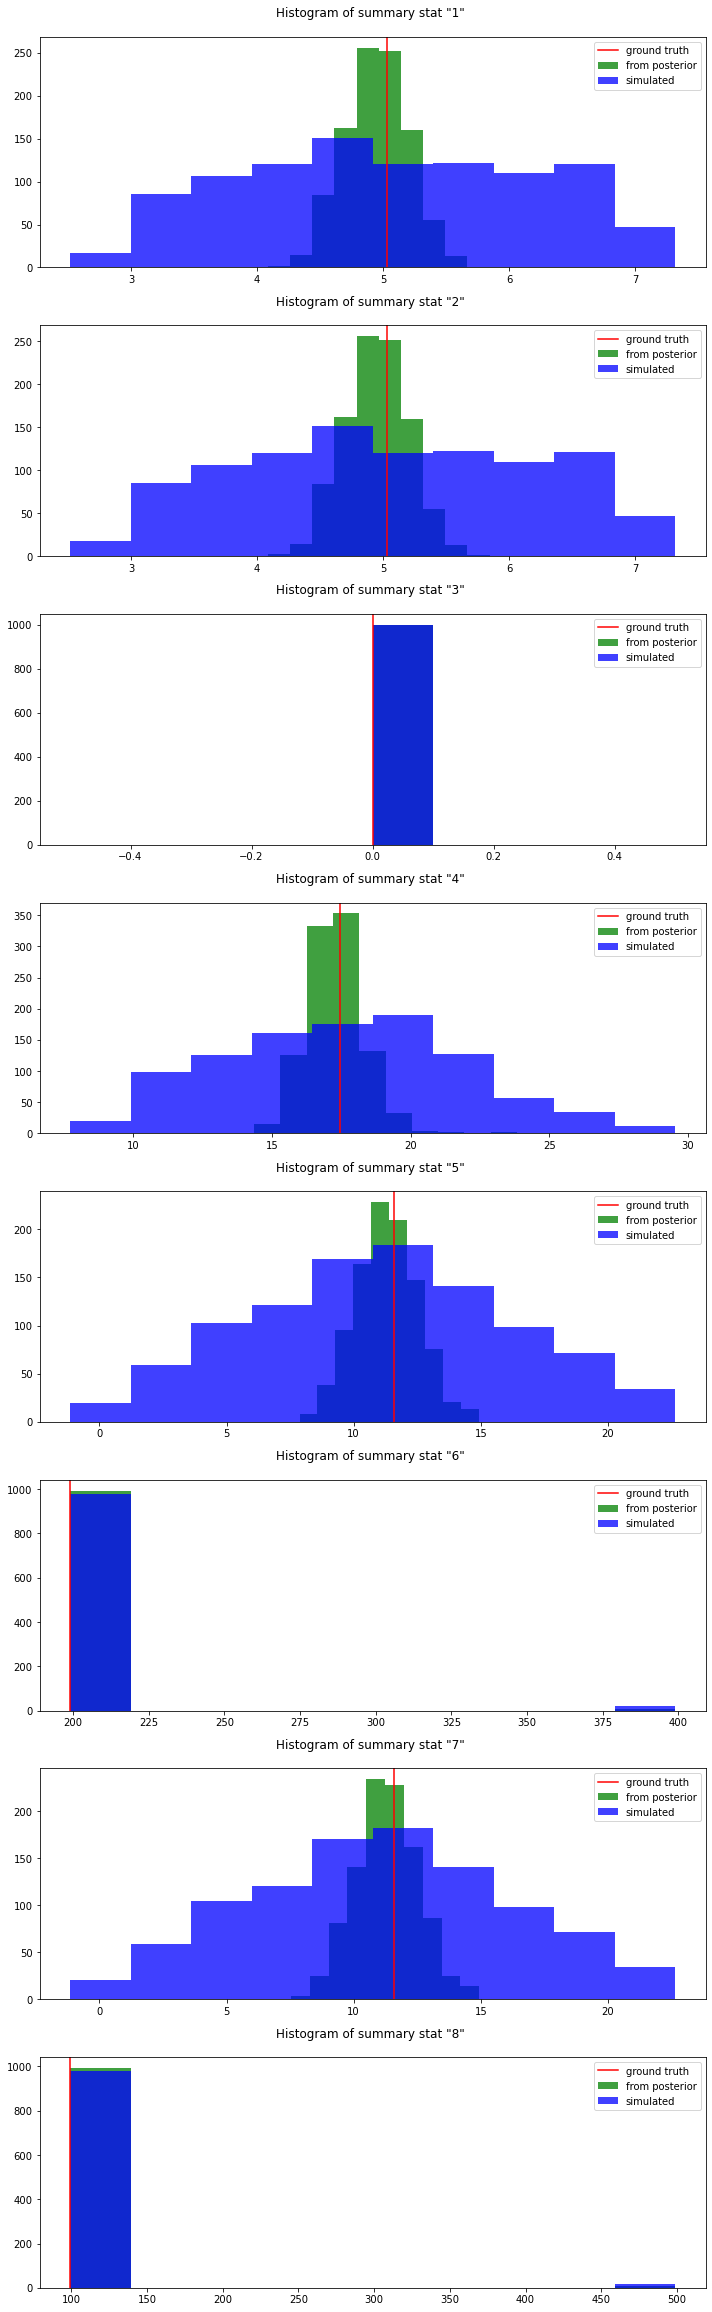

In [98]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)
print(len(s_x_stat[0]))

sum_stats_names = torch.arange(1, len(s_x_stat[0]), 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=False, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=False, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')